In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [19]:
from torchvision.io import read_video
frames, _, _ = read_video(str('/Volumes/GHD/dataset/T0200498/T0200498.MP4'), output_format="TCHW")

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)

/Users/joel/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


KeyboardInterrupt: 

In [ ]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 520, 960]), dtype = torch.float32


In [ ]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [ ]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -4.722807884216309, max = 1.4046363830566406


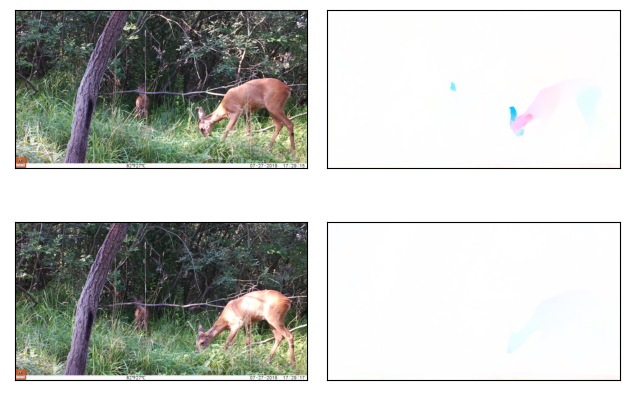

In [ ]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [20]:
from tqdm import tqdm
from PIL import Image

import torch
import torchvision.transforms as transforms
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
from torchvision.utils import flow_to_image

import os
import argparse
import random
import csv

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

In [22]:
weights = Raft_Large_Weights.DEFAULT
optical_transforms = weights.transforms()

In [23]:
frame_1_path = '/Volumes/GHD/dataset/T0200498/frames/1.jpg'
frame_2_path = '/Volumes/GHD/dataset/T0200498/frames/2.jpg'
flow_path = "/Volumes/GHD/dataset/T0200498/flow"

In [24]:
base_transform = transforms.Compose(
  [transforms.ToTensor()]
)

frame_1, frame_2 = optical_transforms(
  base_transform(Image.open(frame_1_path)).unsqueeze(0), base_transform(Image.open(frame_2_path)).unsqueeze(0)
)

In [25]:
list_of_flows = model(frame_1.to(device), frame_2.to(device))
predicted_flows = list_of_flows[-1]
flow_imgs = flow_to_image(predicted_flows).squeeze(0)

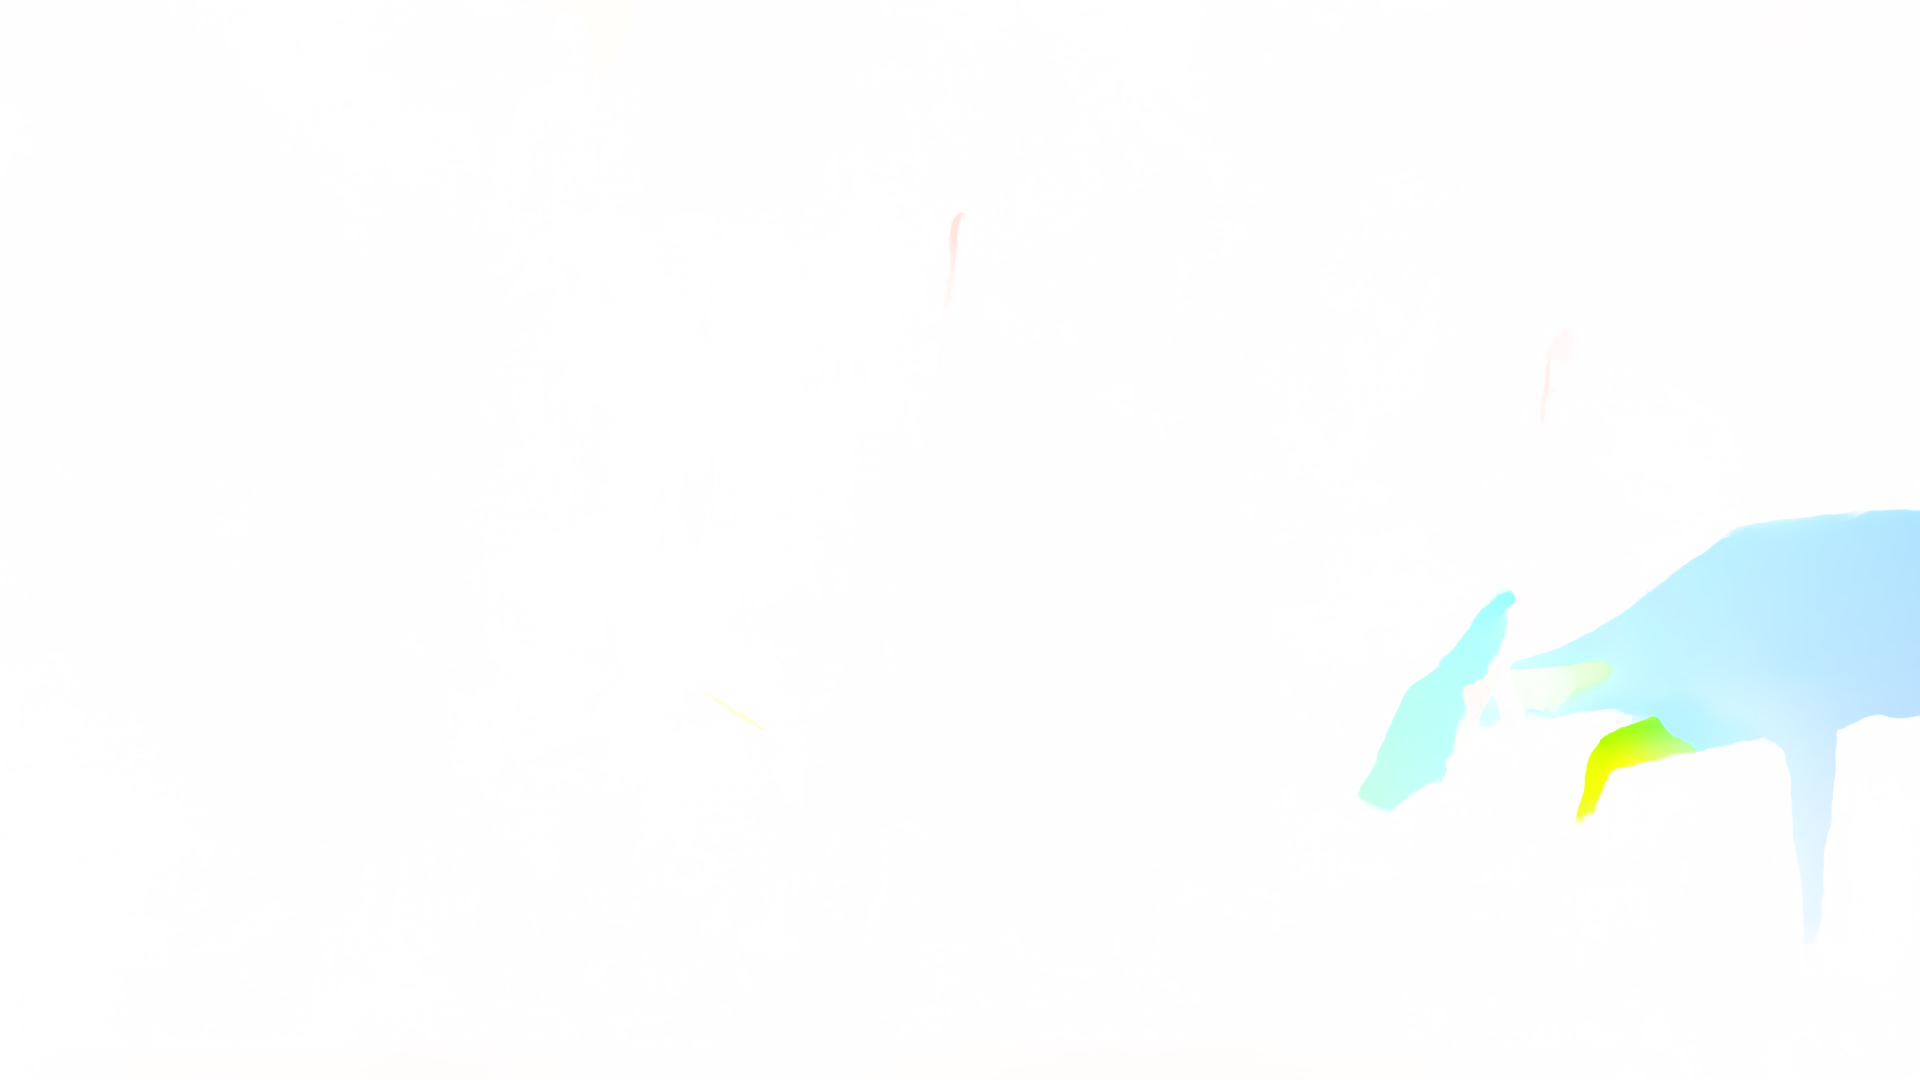

In [30]:
predicted_flows = list_of_flows[-1]
predicted_flows[0,0].size()
transforms.ToPILImage()(flow_imgs)